# Rice Crop Discovery Tool

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one day (21st March 2020), with an assumption that VV and VH values for this day are representative of VV and VH values for the entire year (2020) for a given location.

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [6]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler #5
from sklearn.preprocessing import RobustScaler #4
from sklearn.preprocessing import Normalizer #3
from sklearn.preprocessing import QuantileTransformer #1
from sklearn.preprocessing import PowerTransformer#2


from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
#import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('8797a727c4eb4e9daac78ba400aec737')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
import asyncio
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [7]:
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p>

In [8]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Return RVI (Radar Vegetation Index) value for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    box_size_deg = 0.00036/2 # Surrounding box in degrees, yields approximately 3x3 pixel region
    # 9x9 : 0.00036 R = 69.05 71,11
    # 7x7 : 0.00027 R = 67,62 70 2020-03-20/2020-04-21 : 78.10% 82.22%
    # 5x5 : 0.00036/2 R = 67,86 67,22  79,28 80,56   --> 2021-12-01/2022-04-30 6s 1h
    #3x3 : 0.00036/2/2 R  = 69,29 64,44
    
    
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1]) - box_size_deg, float(latlong[0]) - box_size_deg, float(latlong[1]) + box_size_deg, float(latlong[0]) + box_size_deg)
    time_of_interest = time_slice
    
    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees

    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assets
    #data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    #vh = data["vh"].astype("float").values.tolist()[0][0]
    #vv = data["vv"].astype("float").values.tolist()[0][0]
    #return vh,vv
    dates = []
    rvi = []
    for item in items:
        data = stac_load([item], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale).isel(time=0)
        vh = np.mean(data["vh"].astype("float").values.tolist()[0])
        vv = np.mean(data["vv"].astype("float").values.tolist()[0])
        #vv = np.mean(data["vv"].astype("float").values.tolist()[0])
        dates.append(data["time"].values.tolist())
        rvi.append((1 - vv / (vv+vh))*4*(vh/(vv+vh))**(1/2))
    return dates, rvi

In [ ]:
## Function call to extract VV,VH Values
time_slice = "2021-11-01/2022-06-30"
assests = ['vh','vv']
#vh_vv = []
rvi = []
rvi_data = pd.DataFrame()
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    res = get_sentinel_data(coordinates,time_slice,assests)
    dates_T, rvi_T = res
    rvi_temp = pd.DataFrame([rvi_T], columns = dates_T)
    rvi_data = pd.concat([rvi_data, rvi_temp], ignore_index=True, sort=False)
#rvi_data = pd.DataFrame(rvi,columns =['vh', 'vv', 'rvi'])
#rvi_data = pd.DataFrame(rvi)
rvi_data.to_csv("data.csv",index = False)

 96%|█████████▌| 574/600 [1:40:53<04:22, 10.11s/it]

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [9]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [10]:
#crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data = combine_two_datasets(crop_presence_data,rvi_data)
crop_data.head()

,Latitude and Longitude,Class of Land,1656328317147850000,1656283570363160000,1655291516125679000,1655246769386909000,1654254715667800000,1654209968840031000,1653217914509303000,1653173167705465000,...,1637621168483277000,1637102736313857000,1636629115398152000,1636584368655270000,1636065936411115000,1637102707059227000,1639176306061320000,1640213105181506000,1638139506540090000,1636065907157260000
0,"(10.323727047081501, 105.2516346045924)",Rice,0.500672,0.131031,0.368382,0.366838,0.551380,0.489791,0.653821,0.204114,...,0.123080,0.484832,0.560134,1.042988,1.043604,NaN,NaN,NaN,NaN,NaN
1,"(10.322364360592521, 105.27843410554115)",Rice,0.740986,0.366262,0.312219,0.602416,0.524465,1.001364,0.276666,0.345204,...,0.965395,0.697395,0.881782,0.416461,1.142334,NaN,NaN,NaN,NaN,NaN
2,"(10.321455902933202, 105.25254306225168)",Rice,0.483139,0.584124,0.612397,0.538436,0.722437,0.659176,0.611410,0.376423,...,0.521896,0.375017,0.514941,0.653555,0.806372,NaN,NaN,NaN,NaN,NaN
3,"(10.324181275911162, 105.25118037576274)",Rice,0.685798,0.644853,0.638028,0.669088,0.509676,0.502291,0.190695,0.653289,...,0.323199,0.524784,0.889121,0.263004,0.526352,NaN,NaN,NaN,NaN,NaN
4,"(10.324635504740822, 105.27389181724476)",Rice,0.361253,0.380681,0.637502,0.809790,0.280019,0.945957,0.274718,0.229097,...,0.341931,0.252807,0.611115,0.514853,0.560756,NaN,NaN,NaN,NaN,NaN


## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [11]:
#crop_data = crop_data[['vh','vv','Class of Land']]
crop_data = crop_data.iloc[:, 1:]
crop_data.head()

,Class of Land,1656328317147850000,1656283570363160000,1655291516125679000,1655246769386909000,1654254715667800000,1654209968840031000,1653217914509303000,1653173167705465000,1652181113723854000,...,1637621168483277000,1637102736313857000,1636629115398152000,1636584368655270000,1636065936411115000,1637102707059227000,1639176306061320000,1640213105181506000,1638139506540090000,1636065907157260000
0,Rice,0.500672,0.131031,0.368382,0.366838,0.551380,0.489791,0.653821,0.204114,0.192886,...,0.123080,0.484832,0.560134,1.042988,1.043604,NaN,NaN,NaN,NaN,NaN
1,Rice,0.740986,0.366262,0.312219,0.602416,0.524465,1.001364,0.276666,0.345204,0.122126,...,0.965395,0.697395,0.881782,0.416461,1.142334,NaN,NaN,NaN,NaN,NaN
2,Rice,0.483139,0.584124,0.612397,0.538436,0.722437,0.659176,0.611410,0.376423,0.259472,...,0.521896,0.375017,0.514941,0.653555,0.806372,NaN,NaN,NaN,NaN,NaN
3,Rice,0.685798,0.644853,0.638028,0.669088,0.509676,0.502291,0.190695,0.653289,0.085925,...,0.323199,0.524784,0.889121,0.263004,0.526352,NaN,NaN,NaN,NaN,NaN
4,Rice,0.361253,0.380681,0.637502,0.809790,0.280019,0.945957,0.274718,0.229097,0.098034,...,0.341931,0.252807,0.611115,0.514853,0.560756,NaN,NaN,NaN,NaN,NaN


### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [85]:
X = crop_data.drop(columns=['Class of Land']).values
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X = imputer.fit_transform(X)
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

### Feature Scaling 

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

In [86]:
sc = QuantileTransformer()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

In [87]:
#model = LogisticRegression(solver='lbfgs')
model = svm.SVC(kernel='poly')
model.fit(X_train,y_train)

SVC(kernel='poly')

## Model Evaluation

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [88]:
insample_predictions = model.predict(X_train)

In [89]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       210
        Rice       1.00      1.00      1.00       210

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [76]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

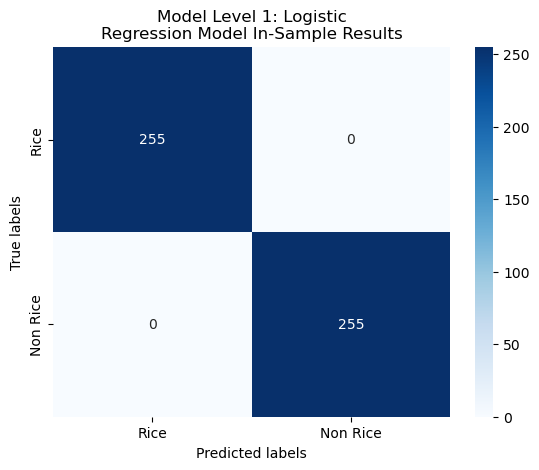

In [77]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

In [91]:
outsample_predictions = model.predict(X_test)

In [92]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 98.89%
              precision    recall  f1-score   support

    Non Rice       0.99      0.99      0.99        90
        Rice       0.99      0.99      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



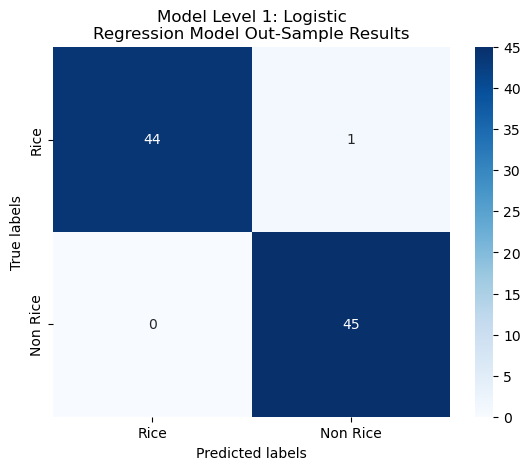

In [80]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

In [37]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"


In [41]:
## Get Sentinel-1-RTC Data
#time_slice = "2020-03-20/2020-03-21"
assests = ['vh','vv']
rvi = []
submission_vh_vv_data = pd.DataFrame()
for coordinates in tqdm(test_file['Latitude and Longitude']):
    res = get_sentinel_data(coordinates,time_slice,assests)
    dates_T, rvi_T = res
    rvi_temp = pd.DataFrame([rvi_T], columns = dates_T)
    submission_vh_vv_data = pd.concat([submission_vh_vv_data, rvi_temp], ignore_index=True, sort=False)

100%|██████████| 250/250 [43:20<00:00, 10.40s/it]


In [42]:
submission_vh_vv_data.head()

,1656328317147850000,1656283570363160000,1655291516125679000,1655246769386909000,1654254715667800000,1654209968840031000,1653217914509303000,1653173167705465000,1652181113723854000,1652136366912236000,...,1637621168483277000,1637102736313857000,1636629115398152000,1636584368655270000,1636065936411115000,1640213105181506000,1639176306061320000,1638139506540090000,1637102707059227000,1636065907157260000
0,0.325736,0.465196,0.451505,0.924676,1.416718,0.888995,0.159204,0.168396,0.258632,0.789761,...,0.773598,0.450226,0.863272,1.502090,0.375275,NaN,NaN,NaN,NaN,NaN
1,0.576524,0.517724,0.574669,0.359337,0.494868,1.141280,0.461330,0.340793,0.112710,0.128441,...,0.198971,NaN,0.330952,0.450150,NaN,0.085691,1.375638,1.013841,0.969030,0.490412
2,0.876066,0.211283,0.691229,0.595536,0.072872,0.077268,0.071984,0.082166,0.065001,0.026638,...,0.065655,NaN,0.254613,0.147362,NaN,0.256798,0.144668,0.388237,0.283898,0.093616
3,0.475102,0.775253,1.144849,0.260058,0.225483,0.510782,0.616450,0.507422,0.161434,0.946416,...,0.628415,NaN,0.647980,0.792498,NaN,0.421587,0.351902,0.617963,0.683792,0.692492
4,0.754807,0.303841,0.607920,0.312153,0.486341,0.356534,1.138858,1.082451,0.348982,0.349192,...,0.537357,0.844547,0.271301,0.640840,1.006530,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [94]:
#Making predictions
imputer = KNNImputer(n_neighbors=2, weights="uniform")
transformed_submission_data = imputer.fit_transform(transformed_submission_data)
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [95]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['Latitude and Longitude'].values, 'target':final_prediction_series.values})

In [96]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [97]:
#Dumping the predictions into a csv file.
submission_df.to_csv("prediction.csv",index = False)